<a href="https://colab.research.google.com/github/hyuna0926/cp2/blob/main/phase2/cohort_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://workingwithpython.com/pythoncohortanalysis/

# 1. 필요 라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

- 데이터 불러오기

In [4]:
trans = pd.read_parquet('/content/drive/MyDrive/CP2_Phase2/transaction_new.parquet')

In [13]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254585 entries, 0 to 1254584
Data columns (total 16 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   created_at              1254585 non-null  category
 1   customer_id             1254585 non-null  int32   
 2   booking_id              1254585 non-null  category
 3   session_id              1254585 non-null  category
 4   payment_method          1254585 non-null  category
 5   payment_status          1254585 non-null  category
 6   promo_amount            1254585 non-null  int16   
 7   promo_code              481139 non-null   category
 8   shipment_fee            1254585 non-null  int32   
 9   shipment_date_limit     1254585 non-null  category
 10  shipment_location_lat   1254585 non-null  int8    
 11  shipment_location_long  1254585 non-null  uint8   
 12  total_amount            1254585 non-null  int32   
 13  product_id              1254585 non-null  

In [14]:
trans = trans[['created_at','customer_id','product_id']]

In [15]:
trans.head()

,created_at,customer_id,product_id
0,2018-07-29T15:22:01.458193Z,5868,54728
1,2018-07-30T12:40:22.365620Z,4774,16193
2,2018-09-15T11:51:17.365620Z,4774,53686
3,2018-11-01T11:23:48.365620Z,4774,20228
4,2018-12-18T11:20:30.365620Z,4774,55220


In [19]:
trans['created_at']=trans['created_at'].apply(lambda x:x[:10])

In [20]:
trans.head()

,created_at,customer_id,product_id
0,2018-07-29,5868,54728
1,2018-07-30,4774,16193
2,2018-09-15,4774,53686
3,2018-11-01,4774,20228
4,2018-12-18,4774,55220


# 2. 코호트 분석

## 2-1. 주문일자(created_at) 칼럼으로 단위 기간 만들기

In [21]:
df = trans.copy()

In [22]:
df['created_at'].dtype

dtype('O')

- 시계열 데이터로 만들어주기

In [26]:
df['created_at']=pd.to_datetime(df['created_at'])

- 코로트 분석 시 데이터를 집계하기 위한 단위 기간은 보통 **월단위**로 진행한다.
- 년, 월 형태로 데이터를 처리하고 OrderPeriod 칼럼 만들어준다.

In [27]:
df['OrderPeriod']=df['created_at'].dt.strftime('%Y-%m')

In [28]:
df.head()

,created_at,customer_id,product_id,OrderPeriod
0,2018-07-29,5868,54728,2018-07
1,2018-07-30,4774,16193,2018-07
2,2018-09-15,4774,53686,2018-09
3,2018-11-01,4774,20228,2018-11
4,2018-12-18,4774,55220,2018-12


## 2-2. 유저의 첫번째 주문을 토대로 유저별 코호트 그룹 설정하기 

코호트 분석의 전제조건 중 동일한 경험을 만드는 과정입니다. 현재 코호트 분석의 주제는 사용자유지율 분석 인데, 실습데이터에서의 동일한 경험이란 **첫 번째 주문**입니다. 이번 과정에서는 각각의 raw에 고객ID별 첫 번째 주문일자를 추가하도록 하겠습니다.

In [29]:
df.set_index('customer_id', inplace=True)
df.head()

,created_at,product_id,OrderPeriod
customer_id,,,
5868,2018-07-29,54728,2018-07
4774,2018-07-30,16193,2018-07
4774,2018-09-15,53686,2018-09
4774,2018-11-01,20228,2018-11
4774,2018-12-18,55220,2018-12


- 첫 번째 주문 컬럼 만들어주기

In [30]:
FirstOrder=df.groupby(df.index)['created_at'].min()
FirstOrder.head()

customer_id
3    2018-08-25
8    2021-02-13
9    2021-06-27
11   2022-03-07
15   2019-09-30
Name: created_at, dtype: datetime64[ns]

In [31]:
FirstOrder=FirstOrder.dt.strftime('%Y-%m')
FirstOrder.head()

customer_id
3     2018-08
8     2021-02
9     2021-06
11    2022-03
15    2019-09
Name: created_at, dtype: object

In [32]:
df['FirstOrder']=FirstOrder
df.reset_index(inplace=True)
df.head()

,customer_id,created_at,product_id,OrderPeriod,FirstOrder
0,5868,2018-07-29,54728,2018-07,2018-07
1,4774,2018-07-30,16193,2018-07,2018-07
2,4774,2018-09-15,53686,2018-09,2018-07
3,4774,2018-11-01,20228,2018-11,2018-07
4,4774,2018-12-18,55220,2018-12,2018-07


## 2-3. 코호트 그룹과 주문기간으로 데이터 집계하기

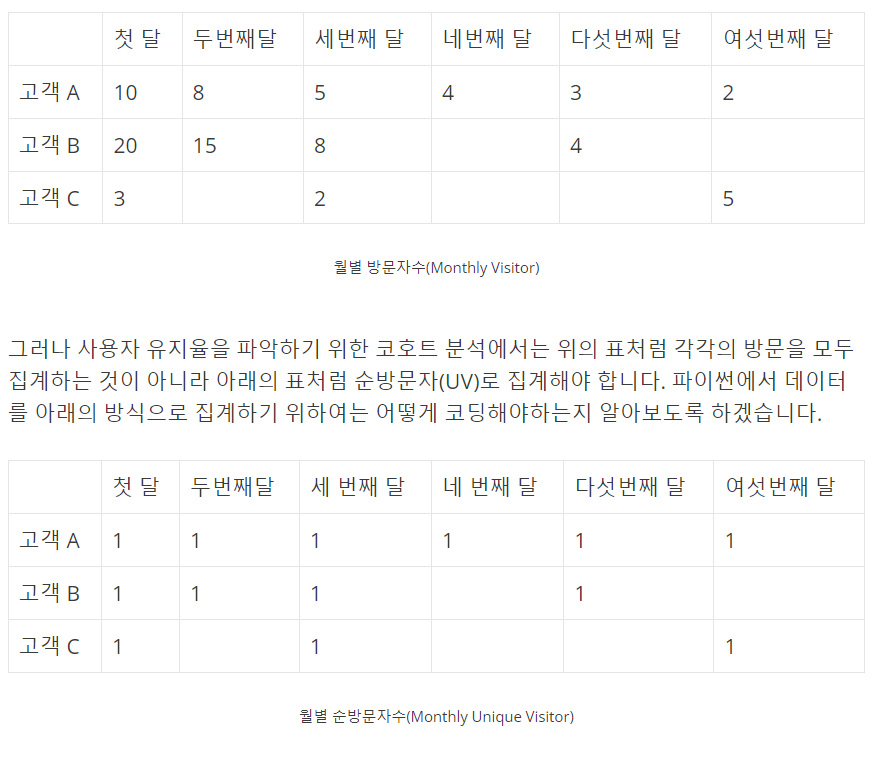

In [33]:
grouped = df.groupby(['FirstOrder', 'OrderPeriod'])

grouped 객체에 고객아이디(UserId)를 집계하며, 집계함수로 각 unique값의 개수를 세는 nunqiue함수를 사용합니다. 이렇게 코딩하면 고객이 여러번 방문했다 하더라도 한 번으로 집계하게 되어 월별 순방문자수를 파악할 수 있습니다.

In [35]:
cohorts=grouped['customer_id'].nunique()
cohorts.head()

FirstOrder  OrderPeriod
2016-06     2016-06        1
            2017-09        1
            2018-12        1
            2020-02        1
            2021-05        1
Name: customer_id, dtype: int64

In [36]:
cohorts=cohorts.reset_index()
cohorts.head()

,FirstOrder,OrderPeriod,customer_id
0,2016-06,2016-06,1
1,2016-06,2017-09,1
2,2016-06,2018-12,1
3,2016-06,2020-02,1
4,2016-06,2021-05,1


In [37]:
cohorts.rename({'customer_id':'TotalUsers'},axis=1,inplace=True)
cohorts.head()

,FirstOrder,OrderPeriod,TotalUsers
0,2016-06,2016-06,1
1,2016-06,2017-09,1
2,2016-06,2018-12,1
3,2016-06,2020-02,1
4,2016-06,2021-05,1


In [38]:
cohorts.tail()

,FirstOrder,OrderPeriod,TotalUsers
2701,2022-05,2022-06,207
2702,2022-05,2022-07,138
2703,2022-06,2022-06,777
2704,2022-06,2022-07,568
2705,2022-07,2022-07,1004


## 2-4. 데이터가 없는 기간 체크 및 데이터 전처리

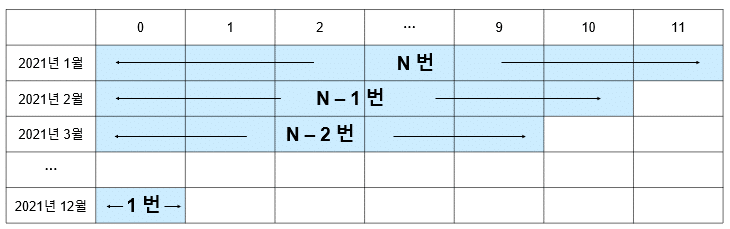

In [39]:
each_period=cohorts['FirstOrder'].value_counts().sort_index()
each_period

2016-06     5
2016-07    73
2016-08    72
2016-09    71
2016-10    70
           ..
2022-03     5
2022-04     4
2022-05     3
2022-06     2
2022-07     1
Name: FirstOrder, Length: 74, dtype: int64

In [41]:
list(each_period) # 2016-06만 이상함

[5,
 73,
 72,
 71,
 70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 53,
 52,
 51,
 50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1]

- 2016-06 드롭

In [45]:
cohorts=cohorts[cohorts['FirstOrder']!='2016-06']

In [46]:
each_period=cohorts['FirstOrder'].value_counts().sort_index()
each_period

2016-07    73
2016-08    72
2016-09    71
2016-10    70
2016-11    69
           ..
2022-03     5
2022-04     4
2022-05     3
2022-06     2
2022-07     1
Name: FirstOrder, Length: 73, dtype: int64

## 2-5. 기간별 레이블 붙이기

코호트 분석에서 처음 들어온 기간은 0, 두번째 기간은 1, 세번째 기간은 2 이런식으로 해야함

In [47]:
cohortperiod=[]

for x in each_period: 
    for y in range(x):
        cohortperiod.append(y)

In [48]:
cohorts['CohortPeriod']=cohortperiod
cohorts.head(20)

,FirstOrder,OrderPeriod,TotalUsers,CohortPeriod
5,2016-07,2016-07,281,0
6,2016-07,2016-08,47,1
7,2016-07,2016-09,62,2
8,2016-07,2016-10,60,3
9,2016-07,2016-11,74,4
10,2016-07,2016-12,68,5
11,2016-07,2017-01,76,6
12,2016-07,2017-02,70,7
13,2016-07,2017-03,72,8
14,2016-07,2017-04,74,9


 - FirstOrder(동일한 경험)와 CohortPeriod(동일한 기간)으로 인덱스로 만들어준다

In [49]:
cohorts.set_index(['FirstOrder','CohortPeriod'],inplace=True)
cohorts.head()

OrderPeriod  TotalUsers
FirstOrder CohortPeriod                        
2016-07    0                2016-07         281
           1                2016-08          47
           2                2016-09          62
           3                2016-10          60
           4                2016-11          74

이 때 **unstack(1)**을 하게되면 생성된 **멀티인덱스 중 두 번째 인덱스(CohortPeriod)가 칼럼으로 변경**되고, 그 결과 **y축은 코호트, x축은 기간**으로 표현되는 코호트 분석의 형태를 갖추게 됩니다.

In [50]:
cohorts=cohorts['TotalUsers'].unstack(1)
cohorts

CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
FirstOrder,,,,,,,,,,,,,,,,,,,,,
2016-07,281.0,47.0,62.0,60.0,74.0,68.0,76.0,70.0,72.0,74.0,...,75.0,73.0,73.0,77.0,67.0,73.0,66.0,59.0,53.0,23.0
2016-08,438.0,96.0,127.0,132.0,146.0,142.0,134.0,142.0,144.0,138.0,...,137.0,149.0,140.0,146.0,130.0,139.0,135.0,106.0,52.0,NaN
2016-09,452.0,83.0,118.0,111.0,132.0,135.0,131.0,121.0,136.0,133.0,...,139.0,121.0,132.0,133.0,122.0,127.0,97.0,39.0,NaN,NaN
2016-10,536.0,110.0,147.0,153.0,154.0,162.0,167.0,168.0,180.0,155.0,...,172.0,151.0,162.0,161.0,153.0,119.0,59.0,NaN,NaN,NaN
2016-11,496.0,99.0,125.0,148.0,141.0,146.0,152.0,141.0,156.0,147.0,...,144.0,142.0,153.0,128.0,109.0,48.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03,886.0,483.0,599.0,515.0,402.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04,873.0,489.0,611.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05,386.0,207.0,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2-6. 코호트별 사용자 유지율 구하기

우리가 흔히 접하는 코호트 분석에는 숫자가 아닌 **비율**로 표현되는 경우가 많습니다.<br><br>
그런데 여기에서 말하는 비율의 의미에 대해 생각해보면, **처음의 순방문자 수에 비해 각 기간의 순방문자수가 얼마나 변화하였는지에 대한 것**이다.<br> 따라서 비율을 구하려면 **전체 데이터를 첫 코호트 기간의 순방문자로 나누어**주면 된다.

In [51]:
cohorts[0] #각 코호트 첫 번째 기간(0주)에 대한 데이터

FirstOrder
2016-07     281.0
2016-08     438.0
2016-09     452.0
2016-10     536.0
2016-11     496.0
            ...  
2022-03     886.0
2022-04     873.0
2022-05     386.0
2022-06     777.0
2022-07    1004.0
Name: 0, Length: 73, dtype: float64

In [52]:
user_retention=cohorts.divide(cohorts[0],axis=0)
user_retention

CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
FirstOrder,,,,,,,,,,,,,,,,,,,,,
2016-07,1.0,0.167260,0.220641,0.213523,0.263345,0.241993,0.270463,0.249110,0.256228,0.263345,...,0.266904,0.259786,0.259786,0.274021,0.238434,0.259786,0.234875,0.209964,0.188612,0.081851
2016-08,1.0,0.219178,0.289954,0.301370,0.333333,0.324201,0.305936,0.324201,0.328767,0.315068,...,0.312785,0.340183,0.319635,0.333333,0.296804,0.317352,0.308219,0.242009,0.118721,NaN
2016-09,1.0,0.183628,0.261062,0.245575,0.292035,0.298673,0.289823,0.267699,0.300885,0.294248,...,0.307522,0.267699,0.292035,0.294248,0.269912,0.280973,0.214602,0.086283,NaN,NaN
2016-10,1.0,0.205224,0.274254,0.285448,0.287313,0.302239,0.311567,0.313433,0.335821,0.289179,...,0.320896,0.281716,0.302239,0.300373,0.285448,0.222015,0.110075,NaN,NaN,NaN
2016-11,1.0,0.199597,0.252016,0.298387,0.284274,0.294355,0.306452,0.284274,0.314516,0.296371,...,0.290323,0.286290,0.308468,0.258065,0.219758,0.096774,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03,1.0,0.545147,0.676072,0.581264,0.453725,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04,1.0,0.560137,0.699885,0.474227,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05,1.0,0.536269,0.357513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2-7. 코호트 시각화

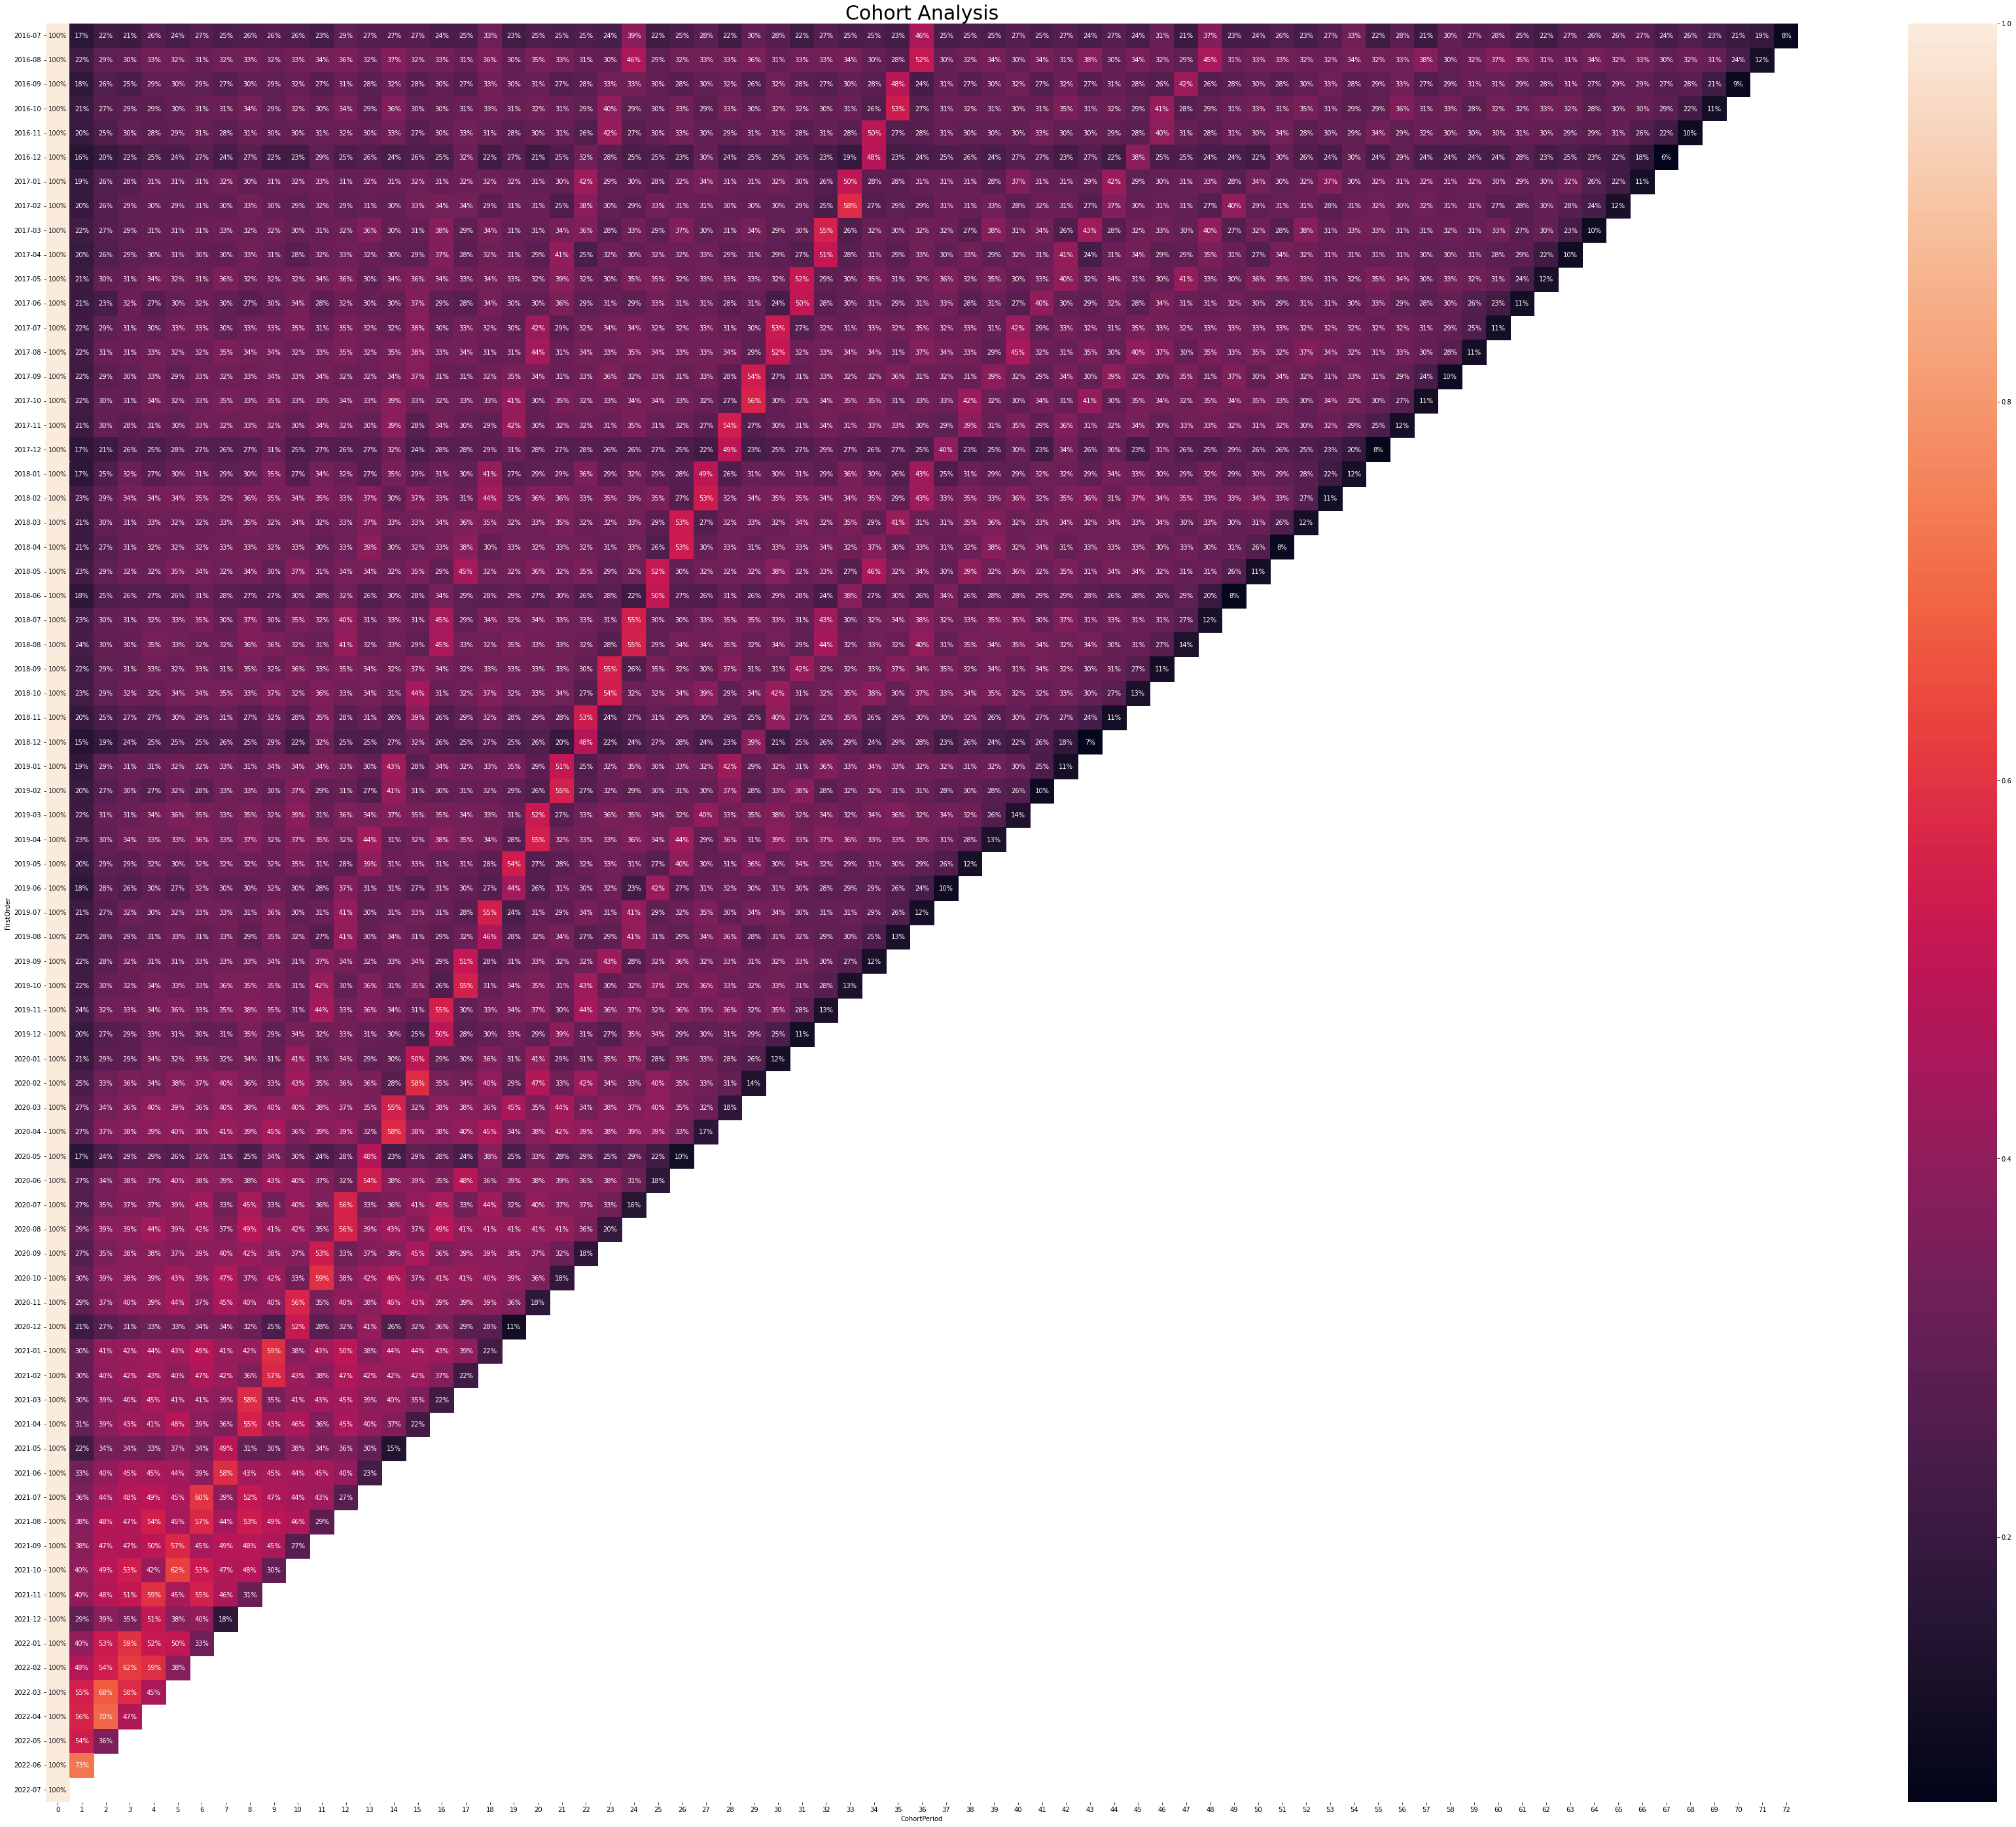

In [56]:
plt.figure(figsize=(60, 50))
plt.title('Cohort Analysis', fontsize=30)
sns.heatmap(user_retention, annot=True, fmt='.0%')
plt.show()